# Capstone Project

Reuben Hough

In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.util.testing as tm
from pandas import DataFrame
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import os
%matplotlib inline
import sys
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from numpy import random
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX as SX
from statsmodels.tsa.seasonal import seasonal_decompose as decomp
from statsmodels.tsa.stattools import adfuller
import itertools
register_matplotlib_converters()
from time import time
import math
from fbprophet import Prophet

In [2]:
Fielder = pd.read_csv('FielderStats.csv')
Pitcher = pd.read_csv('PitcherStats.csv')

In [3]:
FC = Fielder.columns.tolist()[1:]
PC = Pitcher.columns.tolist()[1:]

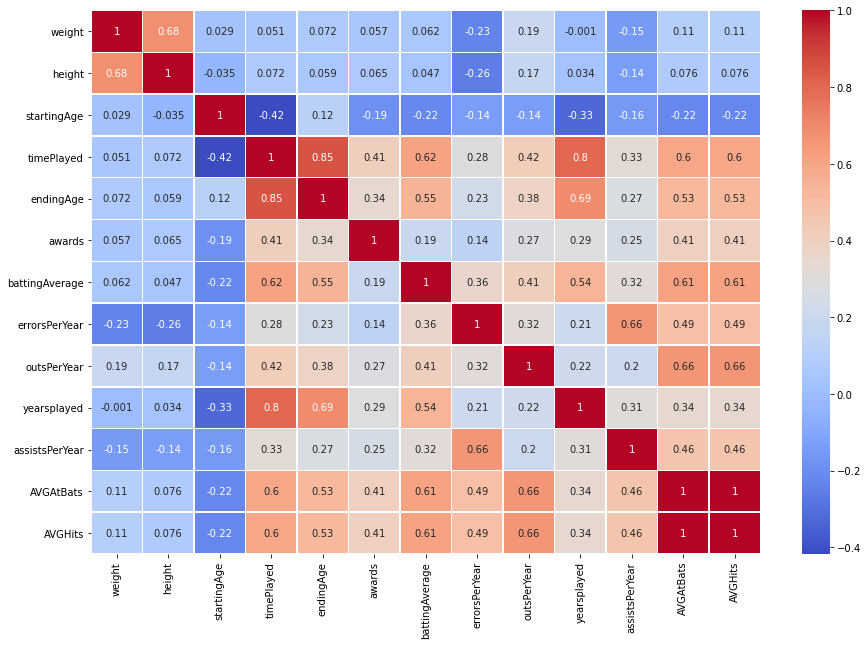

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Fielder[FC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [6]:
# Getting rid of heavily correlated columns
Fielder.drop(['endingAge', 'AVGHits'], axis=1, inplace=True)

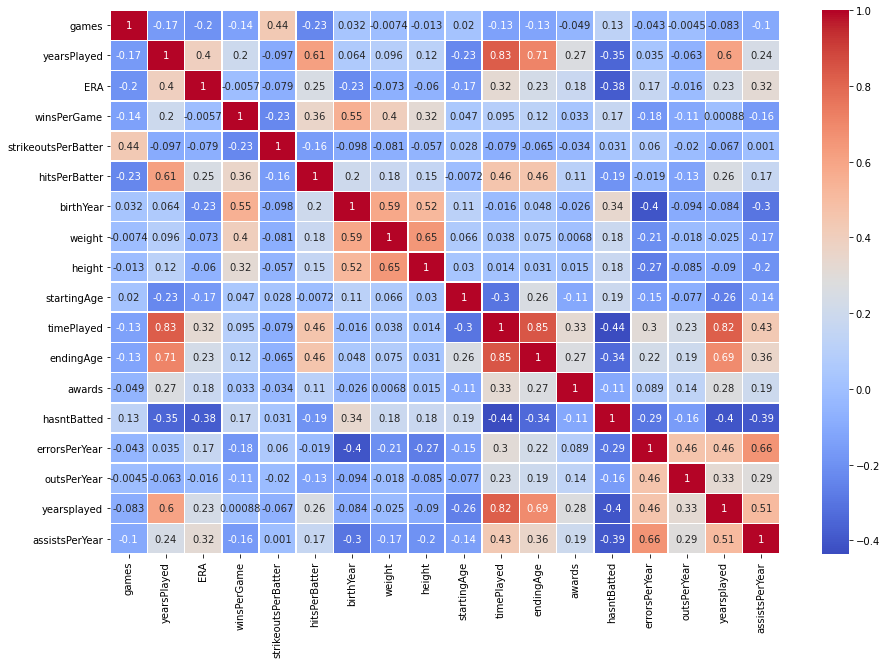

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Pitcher[PC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [9]:
Pitcher.drop('yearsPlayed', axis=1, inplace=True)

In [10]:
# The awards column works out very well, giving me about a tenth of each
# that I know should be relatively good players. I can also see if their stats will predict
# whether they received awards or not
Pitcher2 = Pitcher.copy()
Pitcher2['awards'] = Pitcher2['awards'].where(Pitcher2['awards'] > 0.2, np.NaN)
Pitcher2.dropna()

,playerID,games,ERA,winsPerGame,strikeoutsPerBatter,hitsPerBatter,birthYear,weight,height,startingAge,timePlayed,endingAge,awards,hasntBatted,errorsPerYear,outsPerYear,yearsplayed,assistsPerYear
7,abbotji01,4.496,0.374,0.118,0.250,23.909,1967.0,200.0,75.0,21.58,10.25,31.83,2.0,0.0,0.818,6.545,11.0,27.273
13,abernte02,3.965,0.092,0.141,0.207,40.059,1933.0,215.0,76.0,22.08,17.42,39.50,2.0,0.0,1.235,5.412,17.0,17.882
38,adamsba01,3.734,0.344,0.076,0.257,25.368,1882.0,185.0,71.0,23.92,20.33,44.25,2.0,0.0,0.895,3.053,19.0,34.105
68,ainsmed01,54.000,0.000,0.000,0.667,1.000,1890.0,180.0,71.0,20.50,13.92,34.42,1.0,0.0,9.650,220.500,20.0,54.400
72,akerja01,3.854,0.076,0.114,0.219,35.357,1940.0,190.0,74.0,23.83,10.33,34.17,1.0,0.0,0.571,4.643,14.0,11.929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9450,zachrpa01,3.656,0.280,0.128,0.230,26.636,1952.0,180.0,77.0,24.00,9.08,33.08,1.0,0.0,1.182,5.455,11.0,16.000
9453,zahnge01,4.449,0.289,0.095,0.244,21.714,1945.0,180.0,73.0,27.75,11.92,39.67,1.0,0.0,1.714,6.214,14.0,23.286
9455,zambrca01,4.643,0.360,0.185,0.210,29.500,1981.0,275.0,76.0,20.17,11.08,31.25,3.0,0.0,2.083,14.000,12.0,24.167
9484,zitoba01,4.556,0.354,0.163,0.224,28.867,1978.0,205.0,74.0,22.17,15.17,37.33,4.0,0.0,1.000,5.733,15.0,21.467


In [15]:
# the train sections need to be cut down some to get better results
Fielder2 = Fielder.copy()
Fielder2['errorsPerYear'] = Fielder2['errorsPerYear'].where(Fielder2['errorsPerYear'] > 1, np.NaN)
Fielder2['assistsPerYear'] = Fielder2['assistsPerYear'].where(Fielder2['assistsPerYear'] > 2, np.NaN)
Fielder2['battingAverage'] = Fielder2['battingAverage'].where(Fielder2['battingAverage'] !=0, np.NaN)
Fielder2 = Fielder2.dropna()

In [17]:
Fielder3 = Fielder.copy()
Fielder3['awards'] = Fielder3['awards'].where(Fielder3['awards'] < 0.2, 1)
F3 = Fielder3['awards'].value_counts()
Fielder4 = Fielder2.copy()
Fielder4['awards'] = Fielder4['awards'].where(Fielder4['awards'] < 0.2, 1)
F4 = Fielder4['awards'].value_counts()
print((F3[0])/(F3[1]))
print((F4[0])/(F4[1]))
print(Fielder4.shape[0])

9.419975932611312
5.036319612590799
4986


In [37]:
Pitcher2 = Pitcher.copy()
Pitcher2['ERA'] = Pitcher2['ERA'].where(Pitcher2['ERA'] !=0, np.NaN)
Pitcher2['ERA'] = Pitcher2['ERA'].where(Pitcher2['ERA'] <= 0.8, np.NaN)
Pitcher2['hitsPerBatter'] = Pitcher2['hitsPerBatter'].where(Pitcher2['hitsPerBatter'] >=10, np.NaN)
Pitcher2['winsPerGame'] = Pitcher2['winsPerGame'].where(Pitcher2['winsPerGame'] >=0.05, np.NaN)
Pitcher2['outsPerYear'] = Pitcher2['outsPerYear'].where(Pitcher2['outsPerYear'] >=2, np.NaN)
Pitcher2['errorsPerYear'] = Pitcher2['errorsPerYear'].where(Pitcher2['errorsPerYear'] >=.3, np.NaN)
Pitcher2 = Pitcher2.dropna()

In [38]:
Pitcher3 = Pitcher.copy()
Pitcher3['awards'] = Pitcher3['awards'].where(Pitcher3['awards'] < 0.2, 1)
P3 = Pitcher3['awards'].value_counts()
Pitcher4 = Pitcher2.copy()
Pitcher4['awards'] = Pitcher4['awards'].where(Pitcher4['awards'] < 0.2, 1)
P4 = Pitcher4['awards'].value_counts()
print((P3[0])/(P3[1]))
print((P4[0])/(P4[1]))
print(Pitcher4.shape[0])

16.977272727272727
7.0602409638554215
3345


In [ ]:
Fielder2['awards'] = Fielder2['awards'].where(Fielder2['awards'] < 1.2, 2)
Fielder2['awards'].value_counts()

In [ ]:
Pitcher2['awards'] = Pitcher2['awards'].where(Pitcher2['awards'] < 1.2, 2)
Pitcher2['awards'].value_counts()

Here I made any more than one award equal to two, to simplify categories, and to try and prevent the classifiers from putting all into the no award category.

## Testing Pitchers

In [ ]:
def TestTrain(df):
    y = df['awards']
    x = df.drop(['awards', 'playerID'], axis=1)
    x_train,x_test,y_train,y_test = train_test_split(x,y)
    w = x_train,x_test,y_train,y_test
    return w

In [ ]:
# Using several classifiers to test the data
classifiers = [RidgeClassifier(random_state=1),KNeighborsClassifier(),
               RandomForestClassifier(random_state=1),AdaBoostClassifier(random_state=1),
               DecisionTreeClassifier(random_state=1), LogisticRegression(random_state=1)]
classifiernames = ['Ridge','KNN',"Random Forest","Adaboost","Decision Tree", "Logistic"]

In [ ]:
# Prints accuracy of classification method,
# and provides a visual confusion matrix
def statistics(clf, w):
    print(clf)
    clf.fit(w[0], w[2])
    pred = clf.predict(w[1])
    score = metrics.accuracy_score(w[3], pred)
    print("accuracy:   %0.3f" % score)
    matrix = metrics.confusion_matrix(w[3], pred)
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, matrix

In [ ]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Pitcher2)))

In [ ]:
def Matrix(results, x, name):
    cm = pd.DataFrame(results[x][2], index = [i for i in [0,1,2]],
                  columns = [i for i in [0,1,2]])
    plt.figure(figsize = (10,7))
    plt.title(name[x])
    sns.heatmap(cm, annot=True)

In [ ]:
indices = np.arange(len(results))
for x in indices:
    Matrix(results, x, classifiernames)

## Testing Fielders

In [ ]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Fielder2)))

In [ ]:
indices = np.arange(len(results))
for x in indices:
    Matrix(results, x, classifiernames)

These are not great results as far as correctly classifying awards. It's possible that awards are somewhat arbitrarily handed out.

In [ ]:
# Here I'm going to try to improve the classification by changing the parameters
def SepAward(df):
    data = pd.get_dummies(df,prefix=['awards'], columns = ['awards'], drop_first=False)
    # It may be useful to see each category independently
    NoAward = data.copy()
    OneAward = data.copy()
    TwoAward = data.copy()
    # Making dataframes with only one status accounted for
    NoAward.drop(['awards_1', 'awards_2'], axis=1, inplace=True)
    OneAward.drop(['awards_0', 'awards_2'], axis=1, inplace=True)
    TwoAward.drop(['awards_0', 'awards_1'], axis=1, inplace=True)
    y0 = NoAward['awards_0']
    x0 = NoAward.drop(['awards_0', 'playerID'], axis=1)
    y1 = OneAward['awards_1']
    x1 = OneAward.drop(['awards_1', 'playerID'], axis=1)
    y2 = TwoAward['awards_2']
    x2 = TwoAward.drop(['awards_2', 'playerID'], axis=1)
    # Test/train splitting all of them
    x0train, x0test, y0train, y0test = train_test_split(x0, y0)
    x1train, x1test, y1train, y1test = train_test_split(x1, y1)
    x2train, x2test, y2train, y2test = train_test_split(x2, y2)
    w0 = x0train, x0test, y0train, y0test
    w1 = x1train, x1test, y1train, y1test
    w2 = x2train, x2test, y2train, y2test
    w3 = w0, w1, w2
    return w3

In [ ]:
Pits = SepAward(Pitcher2)
Fiels = SepAward(Fielder2)

## Random Forest Classifier Optimization

Here I'm going to change a few parameters of the classifiers to see if they can work better

In [ ]:
# These are several functions that iterate through parameters to find what works best
def RFEst(w):
    n_estimators = np.linspace(10, 100, 4, endpoint=True, dtype='int')
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for n_estimator in n_estimators:
        dt = RandomForestClassifier(n_estimators=n_estimator, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        # Add auc score to previous train results
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        # Add auc score to previous test results
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(n_estimators, train_results0, 'b', label='No Award Train AUC')
    plt.plot(n_estimators, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(n_estimators, train_results1, 'r', label='One Award Train AUC')
    plt.plot(n_estimators, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(n_estimators, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(n_estimators, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(n_estimators, train_results3, 'black', label='Total Train AUC')
    plt.plot(n_estimators, test_results3, 'dimgray', label='Total Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Number of Estimators')
    plt.legend()
    plt.show()


def RFcrit(w):
    criteria = ['gini', 'entropy']
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for criterion in criteria:
        dt = RandomForestClassifier(criterion=criterion, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(criteria, train_results0, 'b', label='No Award Train AUC')
    plt.plot(criteria, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(criteria, train_results1, 'r', label='One Award Train AUC')
    plt.plot(criteria, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(criteria, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(criteria, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(criteria, train_results3, 'black', label='Total Train AUC')
    plt.plot(criteria, test_results3, 'dimgray', label='Total Test AUC')
    plt.xlabel('Criterion')
    plt.legend()
    plt.show()

# Number of Features
def RFFeat(w):
    max_features = list(range(1, w[0][0].shape[1]))
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for max_feature in max_features:
        dt = RandomForestClassifier(max_features=max_feature, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(max_features, train_results0, 'b', label='No Award Train AUC')
    plt.plot(max_features, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(max_features, train_results1, 'r', label='One Award Train AUC')
    plt.plot(max_features, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(max_features, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(max_features, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(max_features, train_results3, 'black', label='Total Train AUC')
    plt.plot(max_features, test_results3, 'dimgray', label='Total Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Max Features')
    plt.legend()
    plt.show()

In [ ]:
RFEst(Pits)

As the number of estimators increases, up to 40, it seems slightly more accurate at finding awards but less accurate overall.

In [ ]:
# Doing the same with fileding stats.
# No significant difference
RFEst(Fiels)

In [ ]:
RFcrit(Pits)

In [ ]:
RFcrit(Fiels)

In [ ]:
RFFeat(Pits)

Very mild improvement here. It looks like the best option is 8 features

In [ ]:
RFFeat(Fiels)

Similar results with fielders

## Ridge Classifier Optimization

The Ridge Classifier may also be worth looking into; I'll try changing the parameters

In [ ]:
def RCIter(w):
    max_iters = list(range(1, w[0][0].shape[1]))
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for max_iter in max_iters:
        dt = RidgeClassifier(max_iter=max_iter, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(max_iters, train_results0, 'b', label='No Award Train AUC')
    plt.plot(max_iters, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(max_iters, train_results1, 'r', label='One Award Train AUC')
    plt.plot(max_iters, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(max_iters, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(max_iters, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(max_iters, train_results3, 'black', label='Total Train AUC')
    plt.plot(max_iters, test_results3, 'dimgray', label='Total Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Max Iterationss')
    plt.legend()
    plt.show()
    
def RCClass(w):
    class_weights = ['balanced_subsample', 'balanced']
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for class_weight in class_weights:
        dt = RandomForestClassifier(class_weight=class_weight, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(class_weights, train_results0, 'b', label='No Award Train AUC')
    plt.plot(class_weights, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(class_weights, train_results1, 'r', label='One Award Train AUC')
    plt.plot(class_weights, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(class_weights, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(class_weights, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(class_weights, train_results3, 'black', label='Total Train AUC')
    plt.plot(class_weights, test_results3, 'dimgray', label='Total Test AUC')
    plt.xlabel('Class Weight')
    plt.legend()
    plt.show()

In [ ]:
RCIter(Pits)

In [ ]:
RCIter(Fiels)

In [ ]:
RCClass(Pits)

In [ ]:
RCClass(Fiels)

No significant results are apparent

In [ ]:
# Now logistic Regression
def LRpenalty(w):
    penalties = ['l2', 'none']
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for penalty in penalties:
        dt = LogisticRegression(penalty=penalty, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(penalties, train_results0, 'b', label='No Award Train AUC')
    plt.plot(penalties, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(penalties, train_results1, 'r', label='One Award Train AUC')
    plt.plot(penalties, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(penalties, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(penalties, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(penalties, train_results3, 'black', label='Total Train AUC')
    plt.plot(penalties, test_results3, 'dimgray', label='Total Test AUC')
    plt.xlabel('Penalties')
    plt.legend()
    plt.show()
    
def LRpenaltySaga(w):
    penalties = ['l2', 'none']
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for penalty in penalties:
        dt = LogisticRegression(penalty=penalty, solver='saga', random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(penalties, train_results0, 'b', label='No Award Train AUC')
    plt.plot(penalties, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(penalties, train_results1, 'r', label='One Award Train AUC')
    plt.plot(penalties, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(penalties, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(penalties, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(penalties, train_results3, 'black', label='Total Train AUC')
    plt.plot(penalties, test_results3, 'dimgray', label='Total Test AUC')
    plt.xlabel('Penalties')
    plt.legend()
    plt.show()

In [ ]:
LRpenalty(Pits)

In [ ]:
LRpenalty(Fiels)

In [ ]:
LRpenaltySaga(Pits)

In [ ]:
LRpenaltySaga(Fiels)

There may be a slight increase with the 'l2' penalty

In [ ]:
classifiers = [RidgeClassifier(random_state=1),RandomForestClassifier(random_state=1),
               LogisticRegression(random_state=1)]
newClassifiers = [RidgeClassifier(random_state=1),RandomForestClassifier(max_features=5, random_state=1),
                  LogisticRegression(random_state=1)]

In [ ]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Fielder2)))

In [ ]:
results = []
for clf in newClassifiers:
    results.append(statistics(clf, TestTrain(Fielder2)))

## Conclusion

Most of the ~90 percent accuracy was in placing lots of the players into the no award category. Perhaps I need to get more information on the purpose of said awards, as they may not necessarily be for skill.

It seems that logistic regression is better able to classify awarded players, which means that awards aren't so arbitrary after all, but I believe this needs more investigation.

Another possibility is that the data is skewed by the lack of awards prior to 1910, and the dip after WWII.